In [102]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt


def flux(uu, tflx):
    """
    Fonction pour definir les flux des EDP
    """
    if tflx == 0:
        return uu
    elif tflx == 1: #Flux pour l'équation de Burgers
        return uu ** 2 / 2
    else: #Cas plus complexe d'un flux non-convexe
        return 4 * uu ** 2 / (4 * uu ** 2 + (1 - uu) ** 2)


def dflux(uu, tflx):
    """
    Fonction pour définir les dérivés des fluxs des EDP
    """
    if tflx == 0:
        return 1
    elif tflx == 1: #Dérivé flux pour l'équation de Burgers
        return uu
    else: #Dérivé flux plus complexe
        return 8 * uu * (1 - uu) / (4 * uu ** 2 + (1 - uu) ** 2) ** 2


def flux_num(ug, ud, ac, flx_num, tflx):
    """
    Fonction pour écrire la forme visqueuse du flux numérique
    """

    if flx_num == 1: #On utilise Lax-Friedrich global
        ai = ac
    elif flx_num == 2: #On utilise Lax-Friedrich local (Rusanov)
        ai = max(abs(dflux(ug, tflx)), abs(dflux(ud, tflx)))
    else: #On utilise Murman-Roe
        if abs(ud - ug) < 1e-10:
            ai = (abs(dflux(ug, tflx)) + abs(dflux(ud, tflx))) / 2
        else:
            ai = abs((flux(ud, tflx) - flux(ug, tflx)) / (ud - ug))
    return (flux(ug, tflx) + flux(ud, tflx) - ai * (ud - ug)) / 2
    

def u_ini(dini, x):
    """
    Initialisation de la fonction u0
    """
    if dini == 1: #Premier exercice
        return np.sin(2 * np.pi * x)
    elif dini == 2: #Deuxième exercice
        if 0.3 <= x < 0.7:
            return -1
        elif x >= 0.7:
            return 0.5
        else:
            return 0
    else: #Troisième exercice
        if -0.5 < x <= 0:
            return 1
        else:
            return 0


def carac_newton(x, t):
    """
    Implementation méthode de Newton pour trouver le pied de la caractéristique
    """
    X0 = x
    errn = 10
    it = 0
    while errn > 1e-10 and it < 10000:
        Xold = X0
        fct_g = np.sin(2 * np.pi * Xold) * t + Xold - x
        fct_dg = 2 * np.pi * np.cos(2 * np.pi * Xold) * t + 1
        X0 = Xold - fct_g / fct_dg
        errn = abs(X0 - Xold)
        it += 1
    return X0
        

def u_sol(pb, x, tps):
    """
    Solutions analytiques aux EDP
    """
    if pb <= 1: #Solution forte premier exercice
        tc = 1 / (2 * np.pi) #tc c'es le temps jusqu'où la solution forte est valable
        if tps < tc - 1e-10:
            X0 = carac_newton(x, tps)
            return np.sin(2 * np.pi * X0)
    elif pb == 2: #Solution faible entropique deuxième exercice
        if tps < 0.8: #Avant que l'onde de detente rencontre le choc
            if x > 0.3 - tps / 2 and x <= 0.7 - tps:
                return -1
            elif x > 0.7 - tps and x <= 0.7 + tps / 2:
                return (x - 0.7) / tps
            elif x > 0.7 + tps / 2:
                return 0.5
        else: #Après
            xc = -np.sqrt(0.8 * tps) + 0.7
            if x > xc and x <= 0.7 + tps / 2:
                return (x - 0.7) / tps
            elif x > 0.7 + tps / 2:
                return 0.5
    return 0

In [103]:
def LCS(pb, flx_num, Nc, cfl, nimp_tot):

    plt.close("all")
    ##Initialisation pour chacun des exercices
    if pb == 0:
        tflx = 1;dini = 1;xdeb = 0;xfin = 1
        tc = 1 / (2 * np.pi);Tfin = 0.9 * tc
    elif pb == 1:
        tflx = 1;dini = 1;xdeb = 0;xfin = 1
        tc = 1 / (2 * np.pi);Tfin = 4 * tc
    elif pb == 2:
        tflx = 1;dini = 2;xdeb = -1.5;xfin = 1
        Tfin = 3.2
    else:
        tflx = 2;dini = 3;xdeb = -1;xfin = 1
        Tfin = 0.4

    L = xfin - xdeb #longueur du segment où implementer la méthode
    h = L / Nc #delta_x

    u = np.zeros(Nc) #Vecteur pour les fonctions
    x = np.zeros(Nc) #Vecteur pour le maillage d'espace
    for i in range(Nc):
        x[i] = xdeb + (i + 1/2) * h #on donne chaque valeur
        u[i] = u_ini(dini, x[i]) #on donne valeurs d'nitialisation de la solution
    u_old = u.copy() #u0

    Nc_sol = max(Nc, 200) #Pour definir la solution on vera plus des points, pour ça on utilise le max
    us = np.zeros(Nc_sol) #vecteur pour les solutions exactes
    x_sol = np.zeros(Nc_sol) #vecteur pour le maillaige des solutions exactes
    for i in range(Nc_sol):
        x_sol[i] = xdeb + (i + 1/2) * L / Nc_sol
        us[i] = u_ini(dini, x_sol[i])

    if nimp_tot > 1: # on fait pas aucun chose ici
        plt.figure(figsize=(8, 6))
        plt.plot(x_sol, us, linewidth=3, color='red', label='Initial Condition')
        plt.plot(x, u, '-o', linewidth=2, color=(0, 0.5, 0.5), label='Numerical Solution')

    nimp = 1
    nit = 0;time = 0 #On commence le nombre d'iterations et le temps initial
    ac = 2.34           # Cas Buckley : flux non-convexe
    while time < Tfin: #On fare la méthode de volumes finis jusqu'à le temps final
        if pb < 3:
            ac = -1
            for i in range(Nc):
                ac = max(ac, abs(dflux(u[i], tflx))) #façon de choisir le max de la derive le long du maillage
                
        
        deltat = cfl * h / ac #Un pas de temps qui verifie la condition TVD
        lbd = deltat / h #constant pour la méthode à volumes finis

        for i in range(Nc):
            ui = u_old[i] #on initialise Ui
            if i > 0:
                ug = u_old[i - 1] #on definie u gauche
            else: #on défini u gauche pour les extrêmes
                if pb == 2:
                    ug = u_sol(2, xdeb, time)
                else:
                    ug = u_old[Nc - 1]           # condition péridodique
            if i < Nc - 1:
                ud = u_old[i + 1] #on définie u droite
            else: #on définie u droite pour les extrêmes
                if pb == 2:
                    ud = u_sol(2, xfin + h/2, time)
                else:
                    ud = u_old[0]                # condition péridodique

            u[i] = ui - lbd * (flux_num(ui, ud, ac, flx_num, tflx) - flux_num(ug, ui, ac, flx_num, tflx)) #On défini notre schéma aux volumes finis

        time += deltat #On avance le temps
        nit += 1 #On avance les iterations
        u_old = u.copy() #On avance en n donc on a un noveau u initial

        if abs(time - nimp * Tfin / nimp_tot) <= deltat / 2 + np.finfo(float).eps:
            if nimp < nimp_tot:
                if pb < 3:
                    for i in range(Nc_sol):
                        us[i] = u_sol(pb, x_sol[i], time)
                    if pb != 1 or time < 1 / (2 * np.pi):
                        plt.plot(x_sol, us, linewidth=3, color='red')
                plt.plot(x, u, '-o', linewidth=2, color=(0, 0.5, 0.5))
                plt.legend(['exact solution','numerical solution'])
                nimp += 1

    if pb == 3: #On implemente le cas pour l'exercice 3 (solution exacte)
        Nc_sol = 30000
        us = np.zeros(Nc_sol)
        x_sol = np.zeros(Nc_sol)
        
        file_sol = open('buckley.dat', 'r') #comment ouvrir un archive, "r" pour read
        for i in range(Nc_sol):
            a = np.array(file_sol.readline().split(), dtype=float) #on prend les numeros dans le file qu'on vient d'ouvrir
            x_sol[i] = a[0]
            us[i] = a[1]
        file_sol.close()
    elif pb == 1: #On implemente le cas pour l'exercice 1 (solution exacte)
        Nc_sol = 3000
        us = np.zeros(Nc_sol)
        x_sol = np.zeros(Nc_sol)
        
        file_sol = open('burgers_t=4tc.dat', 'r') #Même technique que dans le cas précédent
        for i in range(Nc_sol):
            a = np.array(file_sol.readline().split(), dtype=float)
            x_sol[i] = a[0]
            us[i] = a[1]
        file_sol.close()
    else:
        for i in range(Nc_sol): #On impleente le cas pour les autres exercices (solution exacte)
            us[i] = u_sol(pb, x_sol[i], Tfin)

    plt.plot(x_sol, us, linewidth=3, color='red')
    plt.plot(x, u, '-o', linewidth=2, color=(0, 0.5, 0.5))

    plt.xlabel('x')
    plt.ylabel('u')
    plt.title('Comparaison')
    plt.legend(['Exact solution','Numerical solution'])
    plt.grid(True)
    plt.show()

# Exemple d'appel de la fonction
# LCS(1, 1, 200, 0.5, 5)


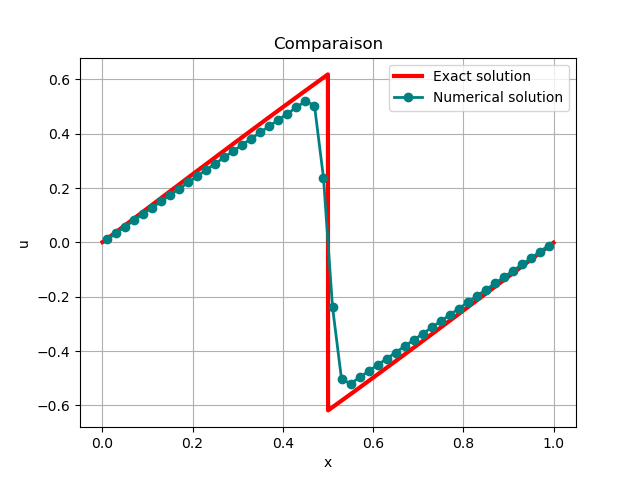

In [104]:
LCS(1, 1, 50, 0.9, 1)